# Vehicle Detection and Tracking

### Project Goal

The goal of the project is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car and to draw boxes around the identified vehicles.



## Classifier

To distinguish between car and non-car images we are going to use the training dataset provided for this project by Udacity:   [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images.

Let's take a look at a vehicle and a non-vehicle image.  First let's make the imports.


In [1]:
%matplotlib inline 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
#import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import io, zipfile

Now let's check a vehicle image without unzipping locally the zip archive:

Number of vehicle images: 8792


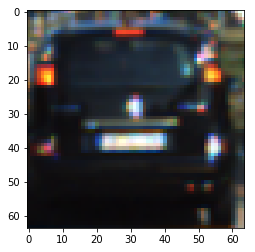

In [23]:
archive = zipfile.ZipFile('vehicles.zip','r')
print('Number of vehicle images:', len(archive.filelist))
f = archive.filelist[0]
fname = f.filename
bytes_io = io.BytesIO(archive.read(fname))
image = mpimg.imread(bytes_io)
plt.imshow(image)

Checking the first non-vehicle image:

Number of non-vehicle images: 9767


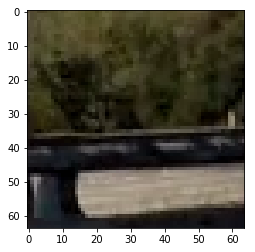

In [24]:
archive = zipfile.ZipFile('non-vehicles.zip','r')
print('Number of non-vehicle images:', len(archive.filelist))
f = archive.filelist[0]
fname = f.filename
bytes_io = io.BytesIO(archive.read(fname))
image = mpimg.imread(bytes_io)
plt.imshow(image)

We are going to distinguish car and non-car images by assigning features to the images.

We are defining a function called *get_hog_features* which will return  HOG features:

In [10]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


Defining function *bin_spatial* to compute binned color features:

In [11]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


Defining function *color_hist* to compute color histogram features:

In [12]:
# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


Defining function *extract_features*.  This function will extract all the features for all the images in a zip archive - without unpacking locally the archive.  When images are in *png* format the image is going to be transformed from [0..1] float range to [0..255] uint8 range.  An added feature is that every image is going to be added twice to the training set - once the original file and once flipped around the vertical axe - this way we are going to double the size of the training set.  When *color_space* specified is 'HSV', 'LUV', 'HLS', 'YUV' or 'YCrCb' then we are going to perform color space conversion.

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(zipname, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                             orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                             spatial_feat=True, hist_feat=True, hog_feat=True):
    archive = zipfile.ZipFile(zipname, 'r')
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for f in archive.filelist:
        file = f.filename
        bytes_io = io.BytesIO(archive.read(file))
        # Read in each one by one
        image = mpimg.imread(bytes_io)
        if file.endswith('png'):    # transform png 0..1 float -> 0..255 uint8
            image = np.uint8(255 * image)
        for flip in range(2):    # add image twice - one orig & one mirrored
            if flip:
                image= cv2.flip(image,1)      # flipping img around y axe
            # start with blank features
            file_features = []
            # apply color conversion if other than 'RGB'
            if color_space in ['HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
                conversion = eval('cv2.COLOR_RGB2' + color_space)
                feature_image = cv2.cvtColor(image, conversion)
            else:
                feature_image = np.copy(image)

            if spatial_feat == True:
                spatial_features = bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


### Parameter Selection

We are going to work with *spatial_size* (12,12) - this is going to contribute with 12 x 12 x 3 = 432 features.

Number of histogram bins *hist_bins* will be set to 64.  This will contribute with 64 x 3 = 192 features.

HOG parameters selected: *orient* will be 19, *pix_per_cell* will be set to 16 and *cell_per_block* will be 2.  On a 64 x 64 pixel image these settings will contribute with 3 x 3 x 2 x 2 x 19 x 3 = 2052 features.

The *color_space* gave best results by setting it to 'LUV'.

In [10]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 19  # HOG orientations 19
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (12, 12) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


We are going to call the *extract_features* function with the above mentioned parameter settings on *vehicles.zip* and *non-vehicles.zip*

In [11]:
cars = 'vehicles.zip'
notcars = 'non-vehicles.zip'

car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)


We are going to normalize the features with *StandardScaler* and we are going to define the labels vector.

In [12]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


Now let's split up our dataset on training and testing data.  We will utilize only 10% of the data as test data - to keep more data for training.

In [14]:
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 55)
X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 19 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2676


We are going to build a classifier based a *LinearSVC*

In [15]:
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


11.03 Seconds to train SVC...
Test Accuracy of SVC =  0.996


Since it takes quite a long time to compute *svc* and *X_scaler* it is better to save them for later use.

In [18]:
# Save svc and X_scaler for later use
import pickle
classifier = {}
classifier["svc"] = svc
classifier["X_scaler"] = X_scaler

# save the parameters used for classification
classifier["color_space"] = color_space         # 'LUV'
classifier["orient"] = orient                   # 19
classifier["pix_per_cell"] = pix_per_cell       # 16
classifier["cell_per_block"] = cell_per_block   # 2
classifier["hog_channel"] = hog_channel         # 'ALL'
classifier["spatial_size"] = spatial_size       # (12,12)
classifier["hist_bins"] = hist_bins             # 64
classifier["spatial_feat"] = spatial_feat       # True
classifier["hist_feat"] = hist_feat             # True
classifier["hog_feat"] = hog_feat               # True

pickle.dump( classifier, open( "classifier.pkl", "wb" ) )


## Prediction

Let's load the previously saved classifier data and the parameters.


In [2]:
%matplotlib inline 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
#import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pickle

classifier = pickle.load( open( "classifier.pkl", "rb" ) )
svc = classifier["svc"]
X_scaler = classifier["X_scaler"]

# load the parameters used for classification
color_space = classifier["color_space"]         # 'LUV'
orient = classifier["orient"]                   # 19
pix_per_cell = classifier["pix_per_cell"]       # 16
cell_per_block = classifier["cell_per_block"]   # 2
hog_channel = classifier["hog_channel"]         # 'ALL'
spatial_size = classifier["spatial_size"]       # (12,12)
hist_bins = classifier["hist_bins"]             # 64
spatial_feat = classifier["spatial_feat"]       # True
hist_feat = classifier["hist_feat"]             # True
hog_feat = classifier["hog_feat"]               # True


Define function *single_img_features* which is going to return features for a single 64 x 64 pixel image.


In [3]:
# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space in ['HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
        conversion = eval('cv2.COLOR_RGB2' + color_space)
        feature_image = cv2.cvtColor(img, conversion)
    else:
        feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


Define function *search_windows* which is going to take an image and a list of windows.  It is going to iterate through all of the windows on the image, it will resize to 64 x 64 pixels, it will extract features and predict with the previously trained classifier whether the windowed image is a car or is a non-car.  It will return a list of windows where the underlying image is predicted to be a car.

In [4]:
# Input: image and the list of windows to be searched (output of slide_window())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  # img[x1:x2, y1:y2]
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


Define function *slide_window* which takes an image, start and stop positions in x and y directions, a window size in x and y and an overlap fraction for x and y.  It will return a list of windows corresponding to the given constraints.

In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


Define function *draw_boxes* which is going to take and image and a list of boxes, it will create a copy of the image and it will return the copy with the rectangles drawn over it.

In [6]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


Let's build a list of 64 x 64 pixel windows which will be tested on a snapshot from the project video.

nr of 64x64 windows: 195


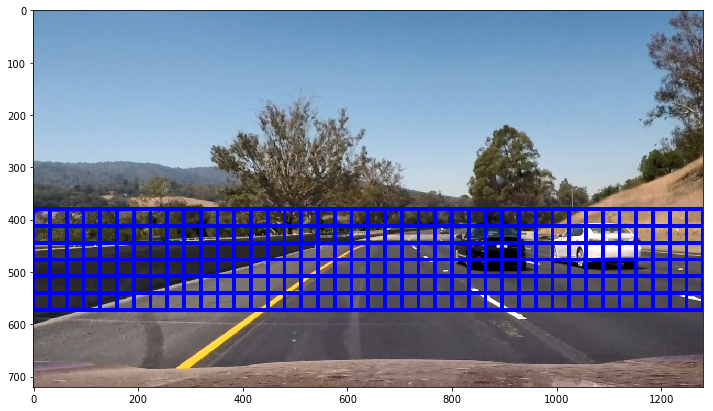

In [7]:
image = mpimg.imread('snapshot_00.37d.jpg')
windows64 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380,580],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
plt.figure(figsize=(12,8))
plt.imshow(draw_boxes(image, windows64, color=(0, 0, 255), thick=6))
print('nr of 64x64 windows:', len(windows64))

Let's take add some more windows with dimensions 96..224 in step of 32 pixels.

nr of 96+ windows: 315


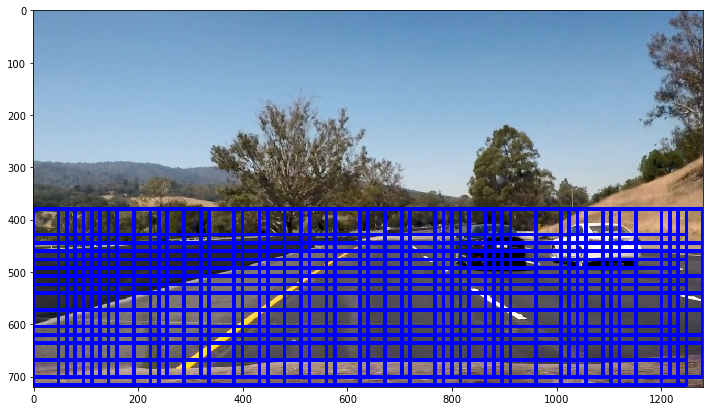

In [8]:
windows96plus = []
for dim in range(96,225,32):
    windows96plus += slide_window(image, x_start_stop=[None, None], y_start_stop=[380,None],
                    xy_window=(dim, dim), xy_overlap=(0.5, 0.5))
plt.figure(figsize=(12,8))
plt.imshow(draw_boxes(image, windows96plus, color=(0, 0, 255), thick=6))
print('nr of 96+ windows:', len(windows96plus))

In total we are going to have 195 + 315 = 510 windows which will be tested whether they contain a car or not.  We have a quite good accuracy ( 99.6% ) however because of a very high number of testing windows we might get some false positives.

prediction time for an image: 1.97


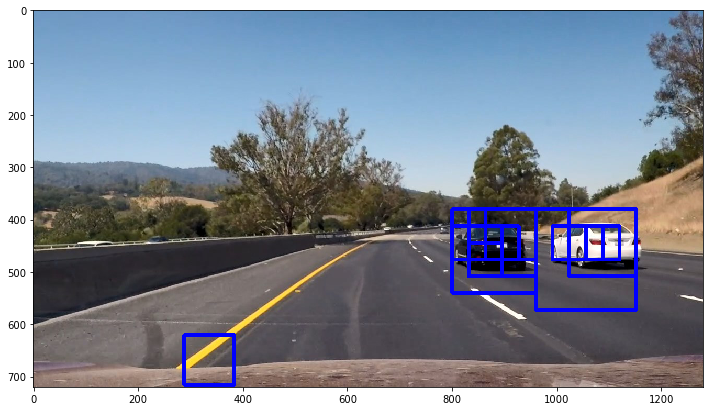

In [13]:
image = mpimg.imread('snapshot_00.37d.jpg')

windows = windows64 + windows96plus
# Check the prediction time for a single sample
t=time.time()

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print('prediction time for an image:', round(t2-t, 2))

plt.figure(figsize=(12,8))

plt.imshow(draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6))

In order to handle multiple detections and false positives let's define function *add_heat* which will build a heatmap based on the pixels inside a *bbox_list*.  Additionally let's define a function *apply_threshold* which will reset pixels in the heatmap which are below the specified threshold.

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap



Let's check the heat on our image:

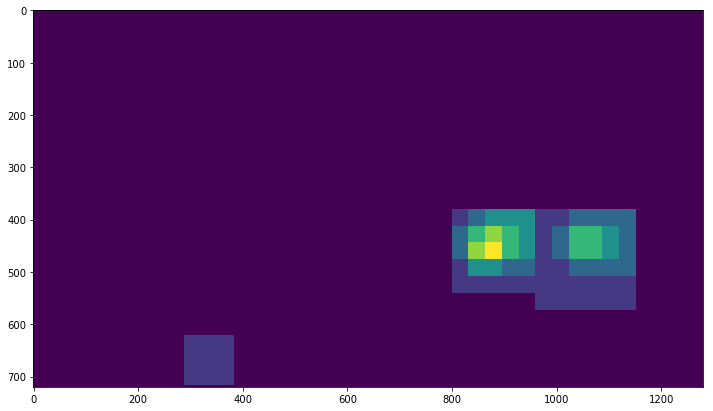

In [15]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, hot_windows)
plt.figure(figsize=(12,8))
plt.imshow(heatmap)

After applying a threshold of 1:

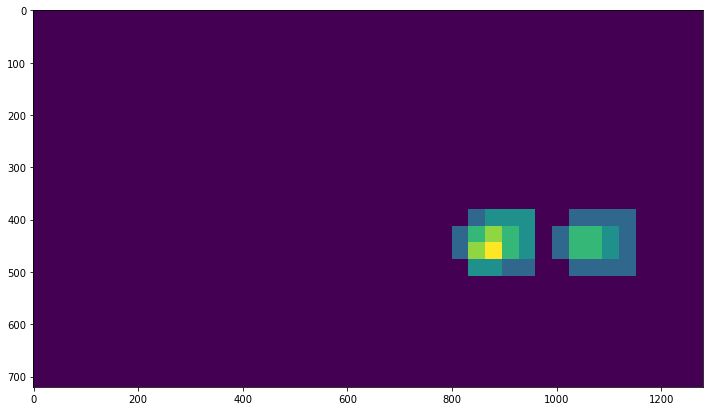

In [16]:
heatmap = apply_threshold(heatmap, 1)
plt.figure(figsize=(12,8))
plt.imshow(heatmap)

We are going to figure out how many cars we have in each frame and which pixels belong to which cars by using the label() function from scipy.ndimage.measurements. 

In [17]:
from scipy.ndimage.measurements import label
labels = label(heatmap)

The variable *labels* is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.

In [18]:
print('There have been', labels[1], 'cars found')

There have been 2 cars found


Define function *draw_labeled_bboxes* which is going to take the *labels* image and put bounding boxes around the labeled regions.

In [19]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


Drawing bounding boxes around a copy of the snapshot image:

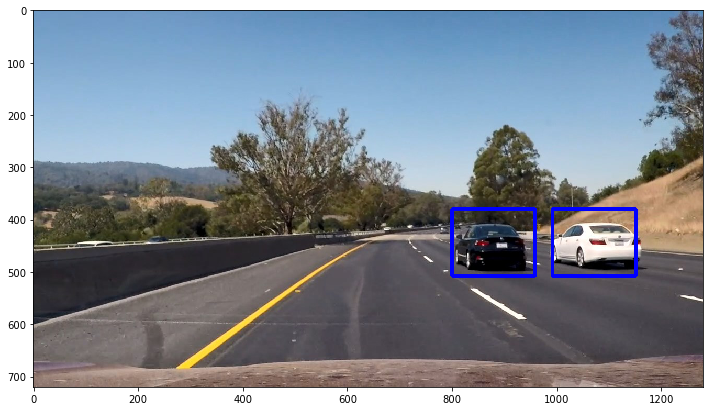

In [20]:
plt.figure(figsize=(12,8))
plt.imshow(draw_labeled_bboxes(np.copy(image), labels))

## Pipeline

We are going to try to stabilize the detection by creating a class *Frame* which is going to hold the last few heatmaps.

In [21]:
class Frame():
    def __init__(self, shape=(720,1280), buffer_size=5):
        self.shape = shape
        self.buffer_size = buffer_size
        self.heat_list = [np.zeros(shape)] * buffer_size

    def buffer_heat(self, hot_windows):
        new_heat = add_heat(np.zeros(self.shape), hot_windows)
        self.heat_list.pop(0)  # remove first heat
        self.heat_list.append(new_heat)
        return np.sum(self.heat_list, axis=0)

frame = Frame()


We are going to define the function *process_frame* which is going to take an image from the video stream and it is going to return the image with the boxes drawn around the vehicles.

In [23]:
def process_frame(image):
    """return image with boxes drawn around cars
    """
    global frame

    # compute window list with cars inside
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    # compute heatmap
#    heat = np.zeros_like(image[:,:,0]).astype(np.float)
#    heatmap = add_heat(heat, hot_windows)
    buf_heat = frame.buffer_heat(hot_windows)
    # apply threshold
    heatmap = apply_threshold(buf_heat, 7)
    # create labels
    labels = label(heatmap)

    return draw_labeled_bboxes(np.copy(image), labels)


Let's take a look how is performing our classification on a pipeline.

In [24]:
from moviepy.editor import VideoFileClip

output = 'project_video_result.mp4'
clip = VideoFileClip("project_video.mp4")
result_clip = clip.fl_image(process_frame) #NOTE: this function expects color images!!
result_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [41:10<00:02,  2.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 



## Discussion

Although my classification algorithm has a pretty good accuracy (99.6%) but it is very slow (processing a frame it takes ~2 seconds).  There are a few false positives - namely the stripes on the road sometimes are classified as vehicles.  This is probably because some of the vehicle images are captured together with road markings.  This could be eliminated with better thresholding and a more advanced tracing of car appearance and disapperance on the frame pipeline.